In [1]:
import sys
sys.path.append('../../../src/')
import re
import pandas as pd
import os
import torch
import esm
from proteusAI.ML.plm import *
from proteusAI.io_tools import *
from scipy.stats import pearsonr
from proteusAI.data.pdb import show_pdb

# Initialize a dictionary to map amino acids to their index in the alphabet
alphabet = alphabet.to_dict()

In [2]:
def parse_substitution(substitution):
    match = re.match(r"([A-Za-z])(\d+)([A-Za-z])", substitution)
    if match:
        return match.groups()
    return None, None, None


def calculate_entropy_correlation(name, seq):
    entropy = torch.load(f"../results/{name}/{name}_per_position_entropy.pt", map_location="cpu")

    # Create a binary vector representing the presence of a mutation at each position
    mutation_occurrence = [0] * len(seq)

    for index, row in data.iterrows():
        if row["gene"] == name:
            wildtype_aa, position, substitute_aa = parse_substitution(row["substitution"])
            if wildtype_aa and position and substitute_aa:
                position = int(position)
                mutation_occurrence[position - 1] = 1

    # Calculate correlation between entropy and whether a mutation occurs at each position
    correlation_entropy_occurrence, _ = pearsonr(entropy[0].numpy(), mutation_occurrence)

    return correlation_entropy_occurrence


def calculate_mmp_correlation(name, seq, vs="average"):
    mmp = torch.load(f"../results/{name}/{name}_masked_marginal_probability.pt", map_location="cpu")

    # Create lists to store the mmp values of the substituted amino acids and the sum of mmp values of all other amino acids
    substituted_mmp_values = []
    other_mmp_values_sum = []

    for index, row in data.iterrows():
        if row["gene"] == name:
            wildtype_aa, position, substitute_aa = parse_substitution(row["substitution"])
            if wildtype_aa and position and substitute_aa:
                position = int(position) - 1  # Convert to 0-indexed
                substitute_aa_index = alphabet[substitute_aa]  # Get the index of the substituted amino acid
                
                # Get the mmp value of the substituted amino acid
                mmp_value = mmp[0, position, substitute_aa_index].item()
                substituted_mmp_values.append(mmp_value)

                # Calculate the sum of mmp values for all other amino acids at the mutated position
                other_mmp_values = [mmp[0, position, i].item() for i in range(mmp.shape[2]) if i != substitute_aa_index]
                if vs == "average":
                    other_mmp_values_sum.append(sum(other_mmp_values)/mmp.shape[2]-1)
                if vs == "sum":
                    other_mmp_values_sum.append(sum(other_mmp_values)/mmp.shape[2])

    # Calculate correlation between the mmp values of the substituted amino acids and the sum of mmp values of all other amino acids
    correlation_substituted_mmp_other_mmp, _ = pearsonr(substituted_mmp_values, other_mmp_values_sum)

    return correlation_substituted_mmp_other_mmp


def plot_entropy_with_highlighted_mutations(name: str, sequence: str):
    # Load the entropy tensor
    entropy = torch.load(f"../results/{name}/{name}_per_position_entropy.pt", map_location="cpu")

    # Find the mutated positions for the given gene
    mutated_positions = []
    for index, row in data.iterrows():
        if row["gene"] == name:
            position = int(row["substitution"][1:-1]) - 1  # 0-indexed
            mutated_positions.append(position)

    title = f"Per position entropy of {name}"
    
    # Plot the per position entropy with highlighted mutated positions
    plot_per_position_entropy(entropy, sequence, highlight_positions=mutated_positions, show=True, title=title)
    
    
def plot_heatmap_with_highlighted_mutations(name: str, sequence: str, alphabet, heatmap_type: str = "mmp"):
    # Load the heatmap tensor based on the heatmap type
    if heatmap_type == "p":
        heatmap_tensor = torch.load(f"../results/{name}/{name}_prob_dist.pt", map_location="cpu")
        color_sheme = "b"
        title = f"Per probability distribution probability of {name}"
    elif heatmap_type == "mmp":
        heatmap_tensor = torch.load(f"../results/{name}/{name}_masked_marginal_probability.pt", map_location="cpu")
        color_sheme = "rwb"
        title = f"Per position masked marginal probability of {name}"
    else:
        raise ValueError("Invalid heatmap_type. Accepted values are 'pd' or 'mmp'.")

    # Find the mutated positions for the given gene
    mutations = {}
    for index, row in data.iterrows():
        if row["gene"] == name:
            position = int(row["substitution"][1:-1]) - 1  # 0-indexed
            mutated_residue = row["substitution"][-1]
            mutations[position] = mutated_residue

    # Plot the heatmap with highlighted mutated positions
    plot_heatmap(heatmap_tensor, alphabet, highlight_positions=mutations, show=True, color_sheme=color_sheme, title=title)

mreB
Pearson correlation for the occurence of mutations based on entropy: 0.0775279792612142
Pearson for of the substituted amino acid being chosen at the mutated position: 0.9524409853202791


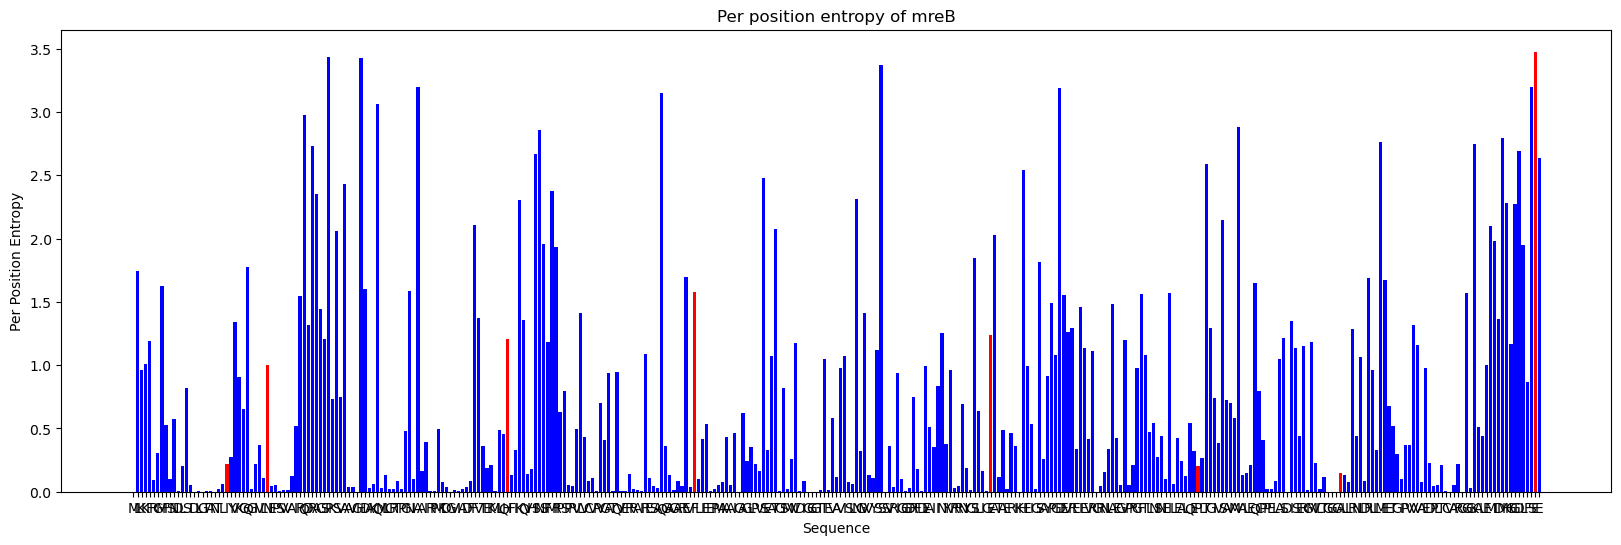

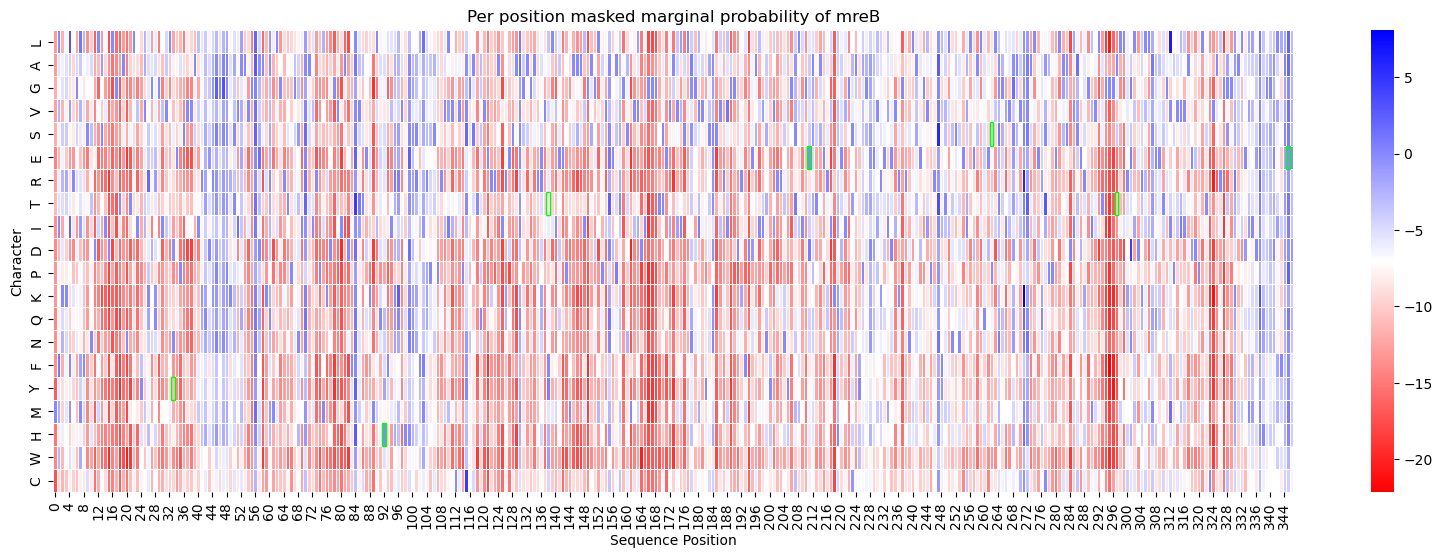

rho
Pearson correlation for the occurence of mutations based on entropy: -0.06341805201748864
Pearson for of the substituted amino acid being chosen at the mutated position: 0.8337756802536559


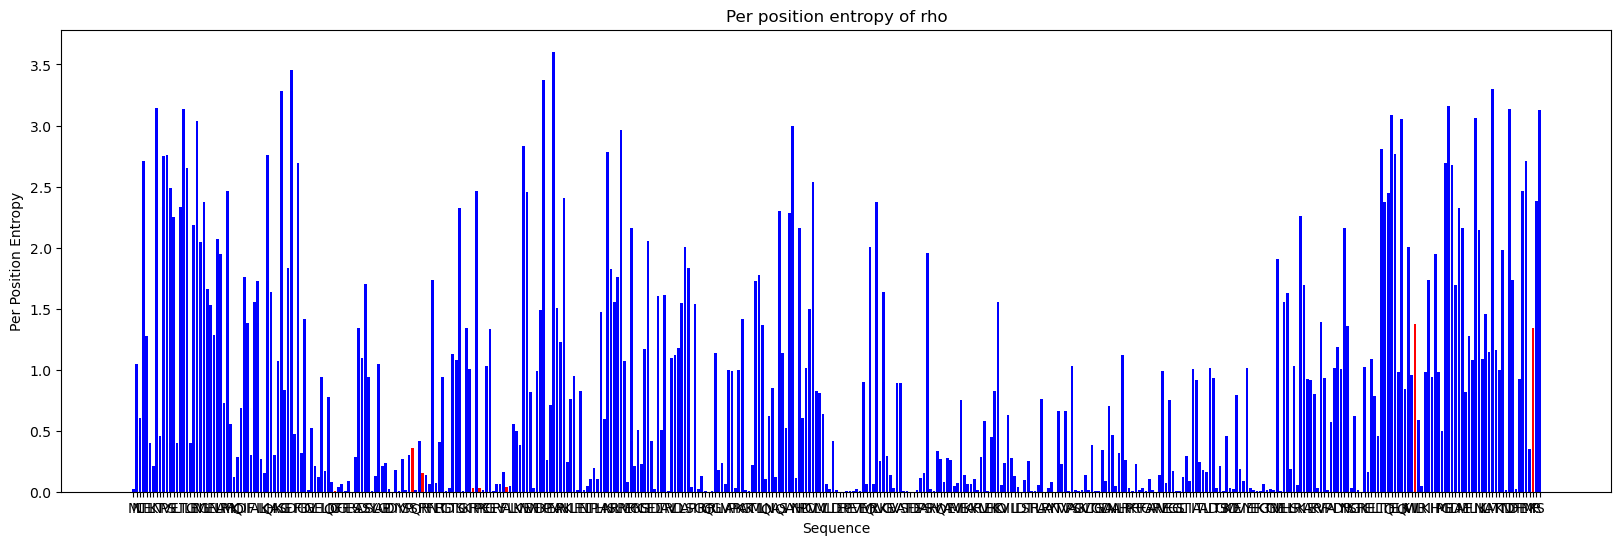

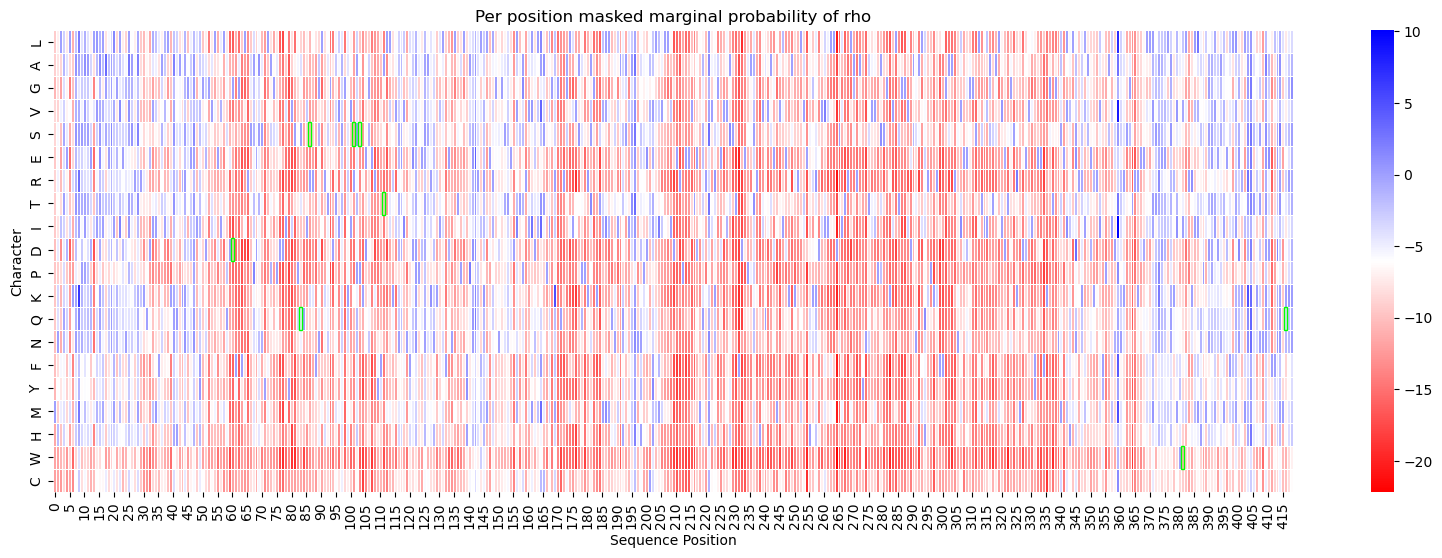

spoT
Pearson correlation for the occurence of mutations based on entropy: -0.09895559614373194
Pearson for of the substituted amino acid being chosen at the mutated position: 0.8100897920561253


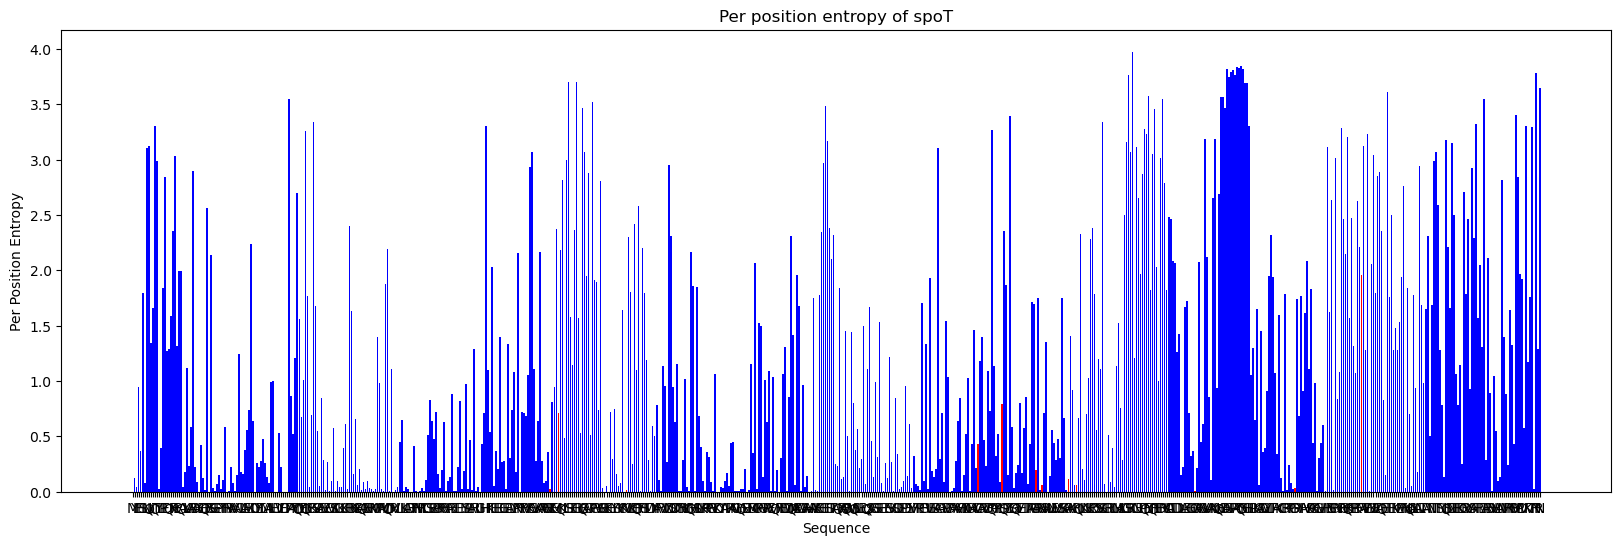

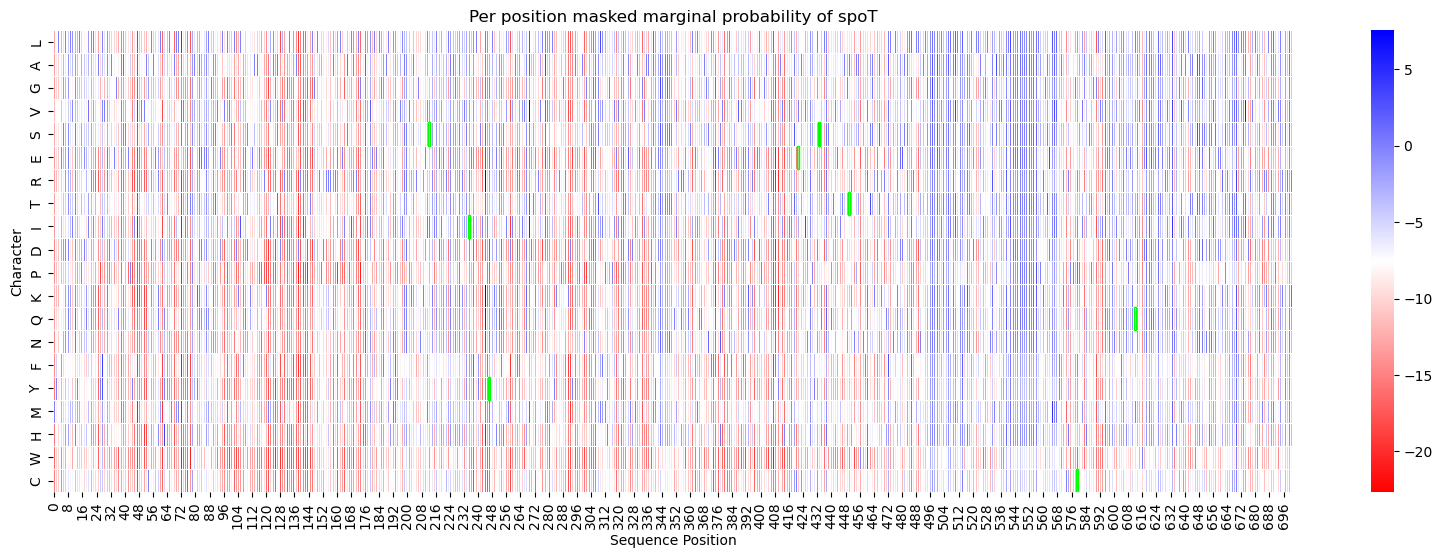

rpoA
Pearson correlation for the occurence of mutations based on entropy: -0.22267009882867272
Pearson for of the substituted amino acid being chosen at the mutated position: 0.7623319106989914


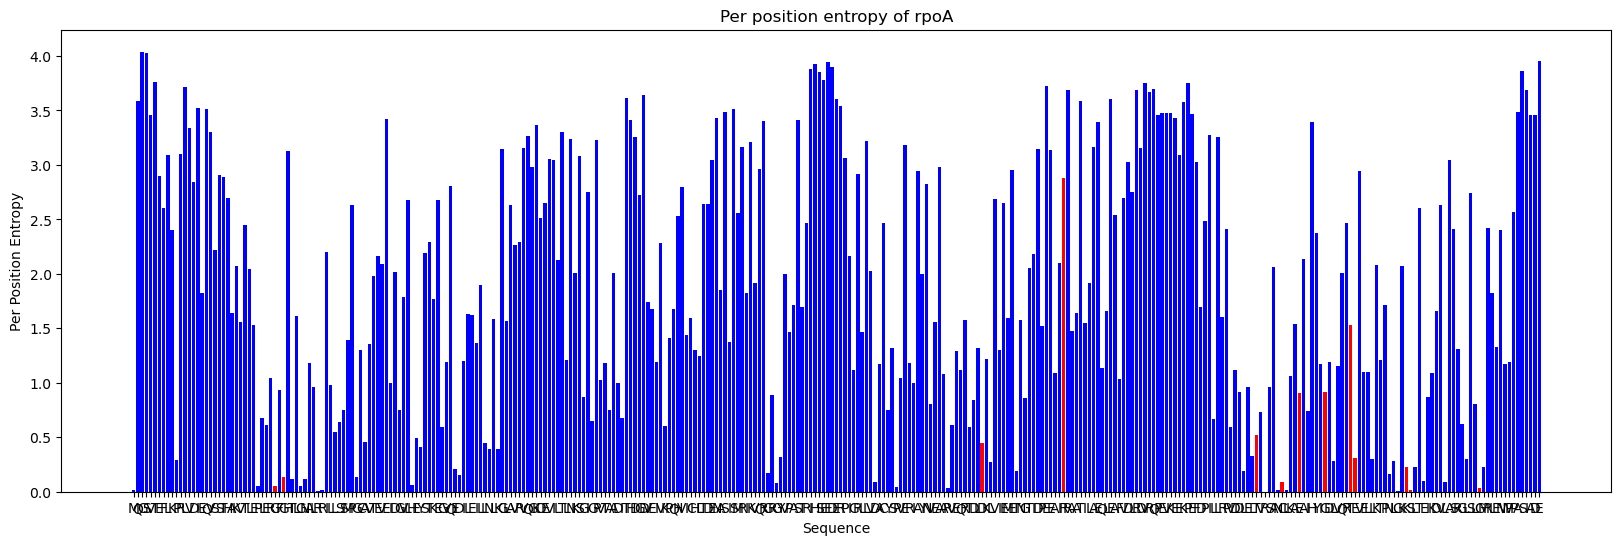

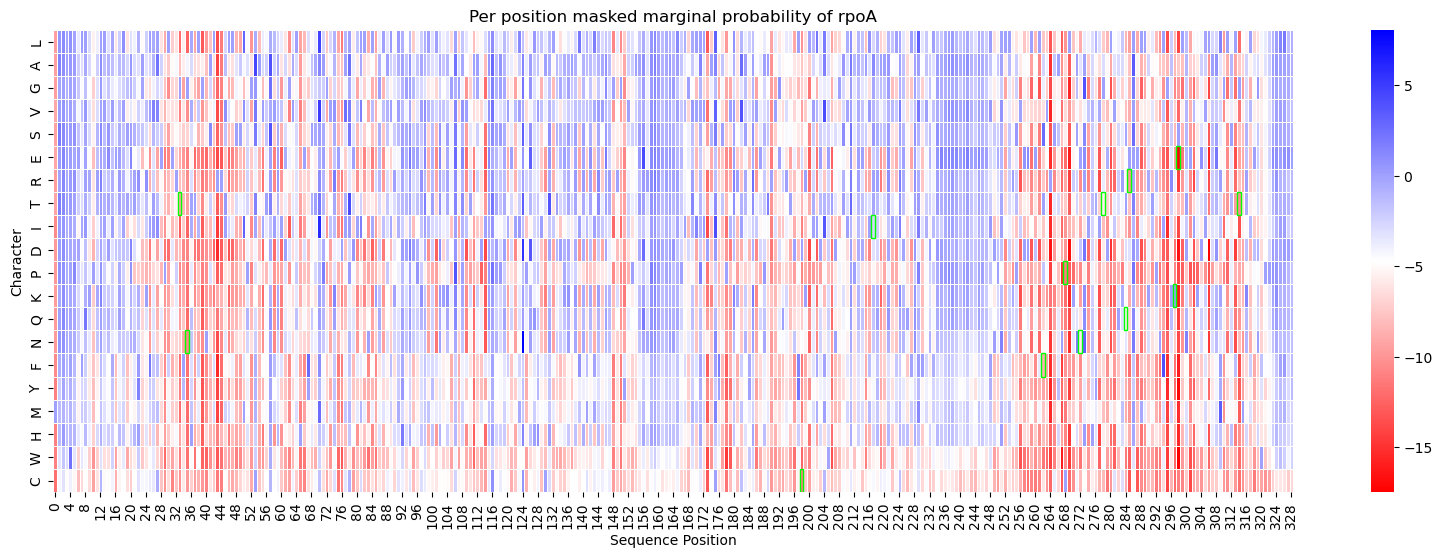

metJ
Pearson correlation for the occurence of mutations based on entropy: -0.10591561731601794
Pearson for of the substituted amino acid being chosen at the mutated position: 0.5287034862130648


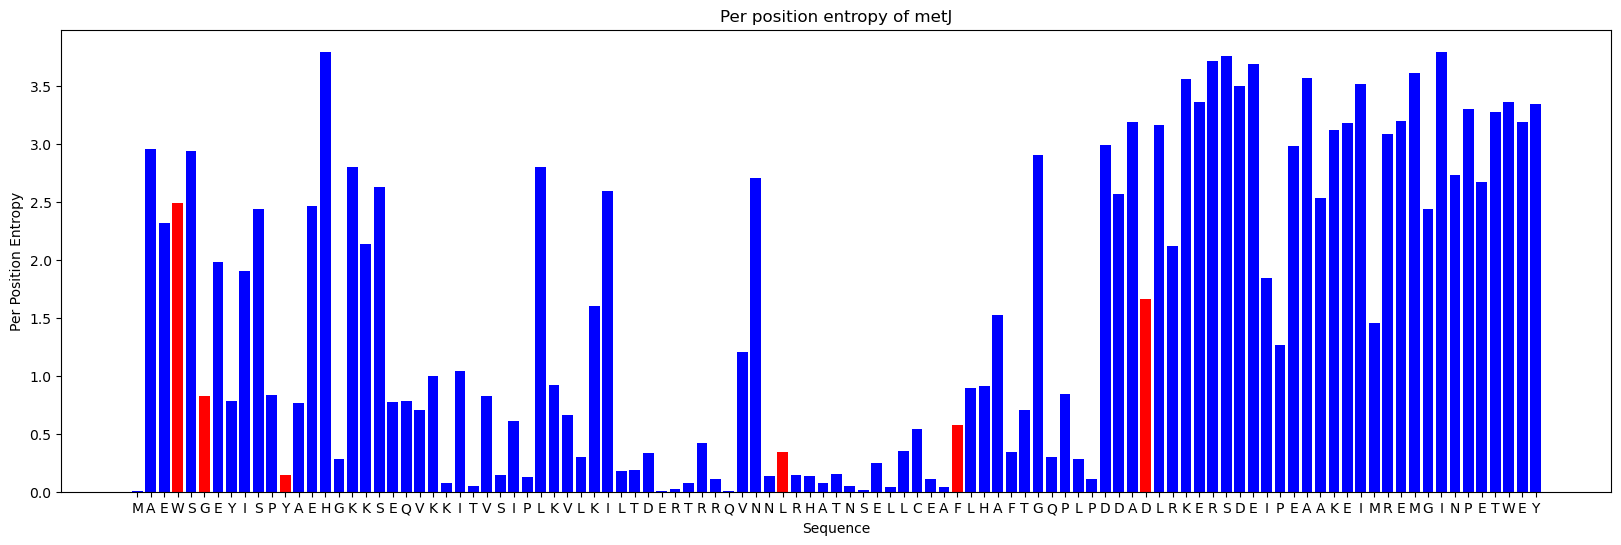

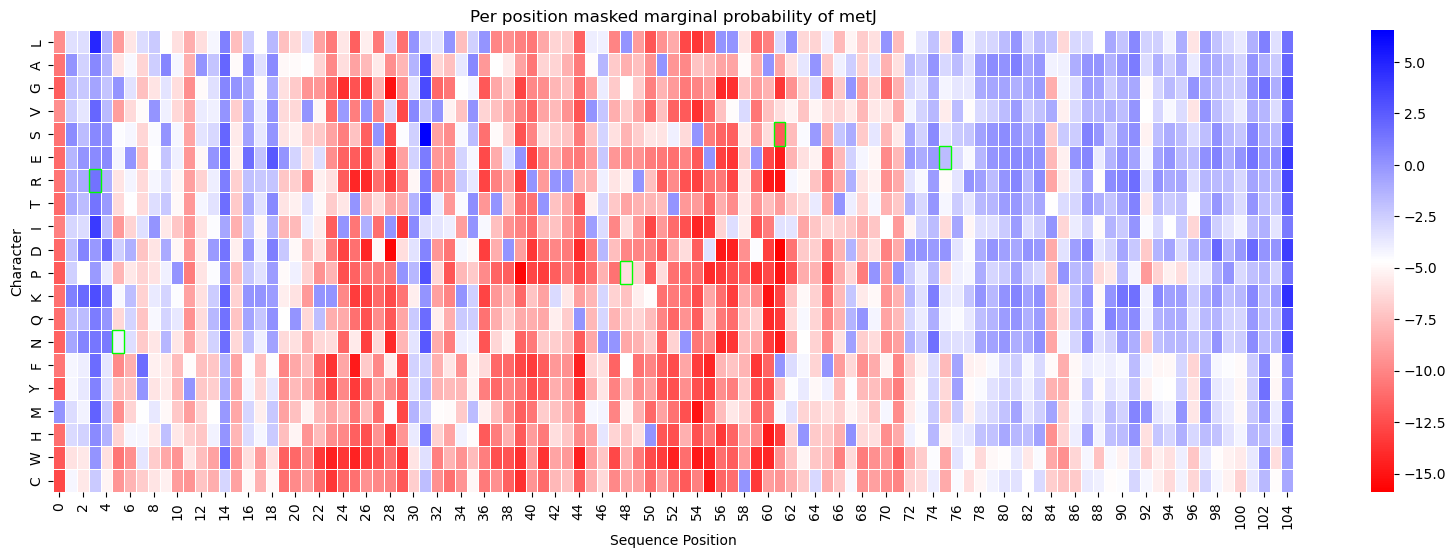

In [3]:
# Load the data
data_path = "../ind_chem_tol_ai-master/"
data = pd.read_csv(os.path.join(data_path, "aledb_snp_df.csv"))
fasta_path = os.path.join(data_path, 'data/fastas')
gene_name_pattern = re.compile(r"GN=([^ ]*)")

names, seqs = load_all_fastas(fasta_path)
names = [gene_name_pattern.search(n).group(1) for n in names if gene_name_pattern.search(n)]

name = names[0]
seq = seqs[0]
for name, seq in zip(names, seqs):
    print(name)
    correlation_entropy_occurrence = calculate_entropy_correlation(name, seq)
    correlation_mmp_occurrence = calculate_mmp_correlation(name, seq)
    print(f"Pearson correlation for the occurence of mutations based on entropy: {correlation_entropy_occurrence}")
    print(f"Pearson for of the substituted amino acid being chosen at the mutated position: {correlation_mmp_occurrence}")
    plot_entropy_with_highlighted_mutations(name, seq)
    plot_heatmap_with_highlighted_mutations(name, seq, alphabet, heatmap_type="mmp")